In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

import pandas as pd
import numpy as np
import nltk

import tensorflow as tf
import re
import random
import spacy

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, callbacks, optimizers
from transformers import AutoTokenizer, TFAutoModel

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

In [6]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [7]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

X_train, X_val, y_train, y_val = train_test_split(
    train['text'], train['target'], test_size=0.2, random_state=SEED
)

In [8]:
MAX_LEN = 50
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

enc_train = tokenizer(
    X_train.tolist(),
    max_length=50,
    truncation=True,
    padding="max_length",
    return_tensors="tf"
)

input_ids_train = enc_train["input_ids"]
attention_mask_train = enc_train["attention_mask"]


enc_val = tokenizer(
    X_val.tolist(),
    max_length=50,
    truncation=True,
    padding="max_length",
    return_tensors="tf"
)

input_ids_val = enc_val["input_ids"]
attention_mask_val = enc_val["attention_mask"]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [9]:
class DistilBertLayer(tf.keras.layers.Layer):
    def __init__(self, model_name="vinai/bertweet-base"):
        super().__init__()
        self.bert = TFAutoModel.from_pretrained(model_name, from_pt=True)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            training=False
        )
        return outputs.last_hidden_state

In [10]:
inputs_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')

bert_outputs = DistilBertLayer()([inputs_ids, attention_mask])

gru = layers.Bidirectional(
    layers.GRU(128, return_sequences=False, dropout=0.3)
)(bert_outputs)
drop2 = layers.Dropout(0.3)(gru)

dense = layers.Dense(64, activation='relu')(drop2)
drop3 = layers.Dropout(0.2)(dense)

output = layers.Dense(1, activation='sigmoid')(drop3)

model = models.Model(inputs=[inputs_ids, attention_mask], outputs=output)

model.compile(optimizer=optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopper = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.001)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If yo

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_layer   │ (None, 50, 768)   │          0 │ input_ids[0][0],  │
│ (DistilBertLayer)   │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    689,664 │ distil_bert_laye… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 706,177 (2.69 MB)

 Trainable params: 706,177 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
hist = model.fit([input_ids_train, attention_mask_train], y_train, epochs=30, validation_data=([input_ids_val, attention_mask_val], y_val), callbacks=[early_stopper], batch_size=64)

Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.6140 - loss: 0.6565 - val_accuracy: 0.7577 - val_loss: 0.5661
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.7238 - loss: 0.5615 - val_accuracy: 0.8011 - val_loss: 0.4769
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.7821 - loss: 0.4837 - val_accuracy: 0.8142 - val_loss: 0.4395
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.8036 - loss: 0.4453 - val_accuracy: 0.8286 - val_loss: 0.4187
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.8117 - loss: 0.4404 - val_accuracy: 0.8293 - val_loss: 0.4118
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.8194 - loss: 0.4216 - val_accuracy: 0.8306 - val_loss: 0.4090
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.8177 - loss: 0.4148 - val_accuracy: 0.8319 - val_loss: 0.4087
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.8200 - loss: 0.4104 - val_accuracy: 0.8345 - v

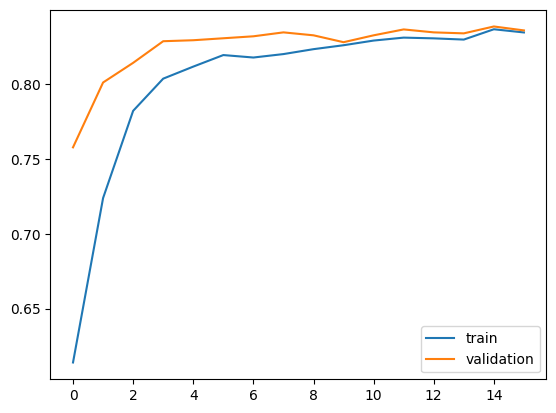

In [13]:
acc = hist.history['accuracy']
acc_val = hist.history['val_accuracy']
plt.plot(acc, label='train')
plt.plot(acc_val, label='validation')
plt.legend()
plt.show()

In [14]:
y_pred = (model.predict([input_ids_val, attention_mask_val]) > 0.5).astype(int)
f1 = f1_score(y_val, y_pred)
print("F1 Score:", f1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 48s 972ms/step
F1 Score: 0.7769028871391076


In [ ]:
enc_text = tokenizer(
    test['text'].tolist(),
    max_length=50,
    truncation=True,
    padding="max_length",
    return_tensors="tf"
)

input_ids_test = enc_text["input_ids"]
attention_mask_test = enc_text["attention_mask"]

y_pred_test = (model.predict([input_ids_test, attention_mask_test]) > 0.5).astype(int)
submission = pd.DataFrame({
    'id': test['id'],
    'target': y_pred_test.flatten()
})
submission.to_csv('submission/neural_network_v3_submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 96s 947ms/step
